In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import Simulation
from committee_learning.result import SimulationResult
import numpy as np
from itertools import product

d_list = [100,1000, 10000]
d_list = [100,1000,2500,5000,7500,10000,12500,15000,20000,25000]
p_list = [1]#,8,16]
k = 1
gamma0 = .1
noise = 1e-3
log_time = 2.

def id_range(d):
  return range(0,int(6500/np.sqrt(d)))

param_list = [(p,d,id) for p,d in list(product(p_list,d_list)) for id in id_range(d)]
# ics = {(p,d) : PhaseDiagramInitialConditions(p,k,True) for p,d in product(p_list,d_list)}
ics = {(p,d,id) : RandomNormalInitialConditions(p,k,d) for p,d,id in param_list}

### Simulations

In [4]:
from tqdm import tqdm
simrs = {}

for key, ic in tqdm(ics.items()):
  p,d,id = key
  # print(f'Simulating d = {d}, p = {p}, id = {id}')
  # Wteacher, W0 = ic.weights(d)
  Wteacher = ic.Wteacher
  W0 = ic.W0
  sim = Simulation(d,p,k,noise,Wteacher,gamma0,'square',W0)
  simr = SimulationResult(initial_condition='random',id=id)
  simr.from_file_or_run(sim,log_time+np.log10(sim.d),path='computation-database/sim/')
  simrs[(p,d,id)] = simr

100%|██████████| 1413/1413 [05:11<00:00,  4.53it/s]


In [5]:
averaged_simulations = {}
averaged_qm = {}
exit_point = {}
for d in d_list:
  for p in p_list:
    data = []
    dataq = []
    datam = []
    datap = []
    how_many_different = set()
    for id in id_range(d):
      how_many_different.add(tuple(simrs[(p,d,id)].risks))
      try:
        assert(simrs[(p,d,1)].steps == simrs[(p,d,id)].steps)
      except:
        print(simrs[(p,d,1)].steps, simrs[(p,d,id)].steps)
        print(d)
      if np.isnan(np.array(simrs[(p,d,id)].risks)).any():
        continue
      data.append(np.array(simrs[(p,d,id)].risks))
      dataq.append(np.array(simrs[(p,d,id)].Qs))
      datam.append(abs(np.array(simrs[(p,d,id)].Ms)))
      datap.append(np.array(simrs[(p,d,id)].P))
    print(f'How many different runs d={d}, p={p}: {len(how_many_different)}')
    data = np.array(data)
    dataq = np.array(dataq)
    datam = np.array(datam)
    datap = np.array(datap) 
    print(d,data.shape)
    average = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    averaged_simulations[(p,d)] = (simrs[(p,d,1)].steps, average, std)
    mean_Q = np.squeeze(np.mean(dataq, axis=0))
    mean_M = np.squeeze(np.mean(datam,axis=0))
    averaged_qm[(p,d)] = (simrs[(p,d,1)].steps, mean_Q, mean_M, np.mean(datap,axis=0))

    exit_point[(p,d)] = simrs[(p,d,1)].steps[np.argmin(mean_Q)]
    exit_point[(p,d)] = simrs[(p,d,1)].steps[np.argmax(mean_M>0.1)]


How many different runs d=100, p=1: 650
100 (647, 300)
How many different runs d=1000, p=1: 205
1000 (205, 400)
How many different runs d=2500, p=1: 130
2500 (130, 500)
How many different runs d=5000, p=1: 91
5000 (91, 500)
How many different runs d=7500, p=1: 75
7500 (75, 500)
How many different runs d=10000, p=1: 65
10000 (65, 500)
How many different runs d=12500, p=1: 58
12500 (58, 600)
How many different runs d=15000, p=1: 53
15000 (53, 600)
How many different runs d=20000, p=1: 45
20000 (45, 600)
How many different runs d=25000, p=1: 41
25000 (41, 600)


### Plot

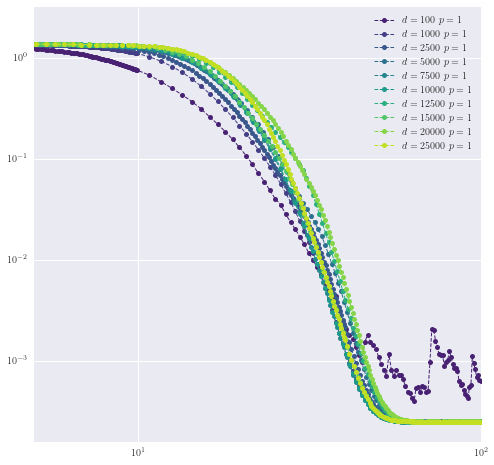

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from committee_learning.utilities import plot_style

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_prop_cycle(color=sns.color_palette("viridis",len(d_list)))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(5,1e2)
  # ax.set_xlim(0,100)
  for key, simr in averaged_simulations.items():
    p,d = key
    # if d != 100:
    #   continue
    steps, risks, rstd = simr
    t = np.array(steps) / d
    # ax.errorbar(t, risks, rstd, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax.plot(t, risks, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    # ax.plot(oders[d].times, oders[d].risks, label='ODE')
  ax.legend()
  plt.show()
  


In [17]:
fixed_d = 10000
with plot_style():
  fig_left, ax_left = plt.subplots(figsize=(2.75,2.75))
  fig_right, ax_right = plt.subplots(figsize=(2.75,2.75))
  fig_left.tight_layout()
  fig_right.tight_layout()

  ax_left.set_xlabel('$t$')
  ax_left.set_ylabel(r'$\mathcal{R}$')
  ax_right.set_xlabel('$t$')
  

  ax_left.set_xscale('log')
  ax_left.set_xlim(0.05,1e2)
  ax_right.set_xscale('log')
  ax_right.set_xlim(0.05,1e2)

  # Exit points
  # ax_left.axvline(exit_point[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')
  # ax_right.axvline(exit_point[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')

  ax_left.set_yscale('log')
  cnt = 0
  for key, simr in simrs.items():
    p,d,id = key
    if d != fixed_d:
      continue
    if np.isnan(np.array(simr.risks)).any():
      continue
    cnt +=1
    t = np.array(simr.steps) / d
    ax_left.plot(t, simr.risks,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.0025*np.sqrt(fixed_d))

  steps, risks, rstd = averaged_simulations[(1,fixed_d)]
  ax_left.plot(t, risks, label=f'average',ls='-',lw=1.,marker='',ms=2.,c='b')
  # ax_left.set_title(f'$d={fixed_d}$, Number of simulations: {cnt}')
  ax_left.legend()

  # ax_right.set_yscale('log')
  for key, simr in averaged_qm.items():
    p,d = key
    if d != fixed_d:
      continue
    steps, Qs, Ms, P = simr
    Qs = np.squeeze(np.array(Qs))
    Ms = np.squeeze(abs(np.array(Ms)))
    P  = np.squeeze(np.array(P))
    t = np.array(steps) / d
    # ax_right.plot(t, Qs, label=f'$Q$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    # ax_right.plot(t, Ms, label=f'$|M|$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax_right.plot(t, Qs, label=f'$q$',ls='--',lw=1.,marker='o',ms=5.)
    ax_right.plot(t, Ms, label=f'$|m|$',ls='--',lw=1.,marker='o',ms=5.)
    ax_right.axhline(P, c='r')
    ax_right.legend()
  
  fig_left.savefig('figures/unconstraned-phase-retrivial-risk.pdf')
  fig_right.savefig('figures/unconstraned-phase-retrivial-qm.pdf')


## Exit point estimation

In [23]:
from scipy.optimize import curve_fit
ds = np.array(d_list, dtype=np.float64)
eps = np.array([exit_point[(1,d)] for d in d_list], dtype=np.float64)
eps /= ds

def loglogline(x,a,C):
  return C*(x**a)

def log(x,a,C):
  return C*np.log(1+a*x)


param_line, cov = curve_fit(loglogline, ds, eps)
a_line, C_line = param_line

param_log, cov = curve_fit(log, ds, eps)
a_log, C_log = param_log

with plot_style():
  fig, ax = plt.subplots(figsize=(5.5,2.75))
  # ax.set_xscale('log')
  # ax.set_yscale('log')

  ax.set_xlabel('$d$')
  ax.set_ylabel('estimated exit time')

  linspace = np.linspace(1, max(d_list), 100)
  ax.plot(linspace, loglogline(linspace,*param_line), label = f'polynomial best fit')
  ax.plot(linspace, log(linspace,*param_log), label = f'logarithmic best fit')

  ax.plot(ds, eps, marker='o',ls='')
  ax.legend()
  fig_left.tight_layout()
  fig.savefig('figures/unconstraned-phase-retrivial-exittimes.pdf')
  

/Users/lucaarnaboldi/Desktop/tesi/proposals/two-layers-networks/x^2-activation-experiment/my-code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
